# Using Orion for Custom Data

This notebook is quick tutorial to use Orion on custom data.

Before you start, please use GPU runtime for faster computation. From the top menu `Runtime -> Change runtime type -> T4 GPU`.

## Step 0: install Orion on Colab
Orion is available on pypi: https://pypi.org/project/orion-ml and can be installed directly via

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
! pip install orion-ml

In [11]:
import os
import orion
import mlstars
from mlblocks import add_pipelines_path, add_primitives_path

# Get the installation directory for the mlstars and orion packages
mlstars_path = os.path.dirname(mlstars.__file__)
orion_path = os.path.dirname(orion.__file__)

# Add the correct, dynamically found DIRECTORY paths
# Changed 'primitives.json' to 'primitives' for the mlstars path
add_primitives_path(os.path.join(mlstars_path, 'primitives'))
add_primitives_path(os.path.join(orion_path, 'primitives'))
add_pipelines_path(os.path.join(orion_path, 'pipelines'))

print("Paths added successfully! ✅")

Paths added successfully! ✅


## Step 1: Load your data from Google Drive

This step assumes that the data is already uploaded to Google Drive. If not, please pause here and upload your data to any desired folder in your Drive.

Next, mount your Drive such that Google Colab can access the files there.

In [13]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


After mounting your drive, you should see a folder named `gdrive` in the "Files" tab on the left hand side.

Specify the location of the file (`file_path`) and load it using `pandas` into a dataframe.

Note: for the sake of running this tutorial, we load an existing signal supported by the Orion library.

In [14]:
import pandas as pd

file_path = '/content/gdrive/MyDrive/Colab Notebooks/Traffic analysis/Datasets/cs_inbound_AT01.csv'

data = pd.read_csv(file_path)

In [15]:
# read data

data.head()

,timestamp,value
0,2024-11-01 00:00:00,22.580645
1,2024-11-01 00:15:00,74.855305
2,2024-11-01 00:30:00,0.000000
3,2024-11-01 00:45:00,0.000000
4,2024-11-01 01:00:00,19.696970


If your data is not following the Orion standard, we need to format it such that it contains two columns:
- **timestamp**: an integer representation of time.
- **values**: the observed value of the time series at that specific time.

Format the data if necessary

In [16]:
import pandas as pd
import numpy as np

# convert the timestamp column into timestamps (integer values)

timestamps = pd.to_datetime(data['timestamp'])
data['timestamp'] = timestamps.values.astype(np.int64) // 10 ** 9

# rename columns in the dataframe to two important columns: timestamp, and value

data = data.rename({"timestamp": "timestamp", "value": "value"})
data.head()

,timestamp,value
0,1730419200,22.580645
1,1730420100,74.855305
2,1730421000,0.000000
3,1730421900,0.000000
4,1730422800,19.696970


## Step 2: Run Orion

Use Orion to find anomalies in your time series signal.

Orion provides a collection of anomaly detection pipelines which you can choose from. You can view the pipelines and their ranking in our [leaderbord](https://github.com/sintel-dev/Orion?tab=readme-ov-file#leaderboard).

In this tutorial, we will use `AER` model.

In [17]:
from orion import Orion

hyperparameters = { # alter the hyperparameter settings here
    'mlstars.custom.timeseries_preprocessing.time_segments_aggregate#1': {
        'interval': 21600
    },
    'orion.primitives.aer.AER#1': {
        'epochs': 5,
        'verbose': True
    }
}

orion = Orion(
    pipeline='aer',
    hyperparameters=hyperparameters
)

orion.fit(data)

Epoch 1/5
4/4 [==============================] - 13s 753ms/step - loss: 0.6919 - tf.__operators__.getitem_loss: 0.6856 - tf.__operators__.getitem_1_loss: 0.6859 - tf.__operators__.getitem_2_loss: 0.7102 - val_loss: 0.2878 - val_tf.__operators__.getitem_loss: 0.4020 - val_tf.__operators__.getitem_1_loss: 0.1852 - val_tf.__operators__.getitem_2_loss: 0.3786
Epoch 2/5
4/4 [==============================] - 1s 202ms/step - loss: 0.2183 - tf.__operators__.getitem_loss: 0.2573 - tf.__operators__.getitem_1_loss: 0.1392 - tf.__operators__.getitem_2_loss: 0.3376 - val_loss: 0.0525 - val_tf.__operators__.getitem_loss: 0.0596 - val_tf.__operators__.getitem_1_loss: 0.0357 - val_tf.__operators__.getitem_2_loss: 0.0789
Epoch 3/5
4/4 [==============================] - 1s 223ms/step - loss: 0.1213 - tf.__operators__.getitem_loss: 0.0990 - tf.__operators__.getitem_1_loss: 0.1431 - tf.__operators__.getitem_2_loss: 0.1002 - val_loss: 0.1381 - val_tf.__operators__.getitem_loss: 0.0024 - val_tf.__operators

In [18]:
import warnings

# Ignore all FutureWarning messages
# Else we get lots of warnings in the output
warnings.filterwarnings('ignore', category=FutureWarning)

Now we can use the trained pipeline to find anomalies:

In [19]:
print("\nDetecting anomalies...")
anomalies = orion.detect(data)

print("\nDetected anomalies:")
print(anomalies)


Detecting anomalies...
9/9 [==============================] - 1s 12ms/step

Detected anomalies:
        start         end  severity
0  1730700000  1732449600  0.165338


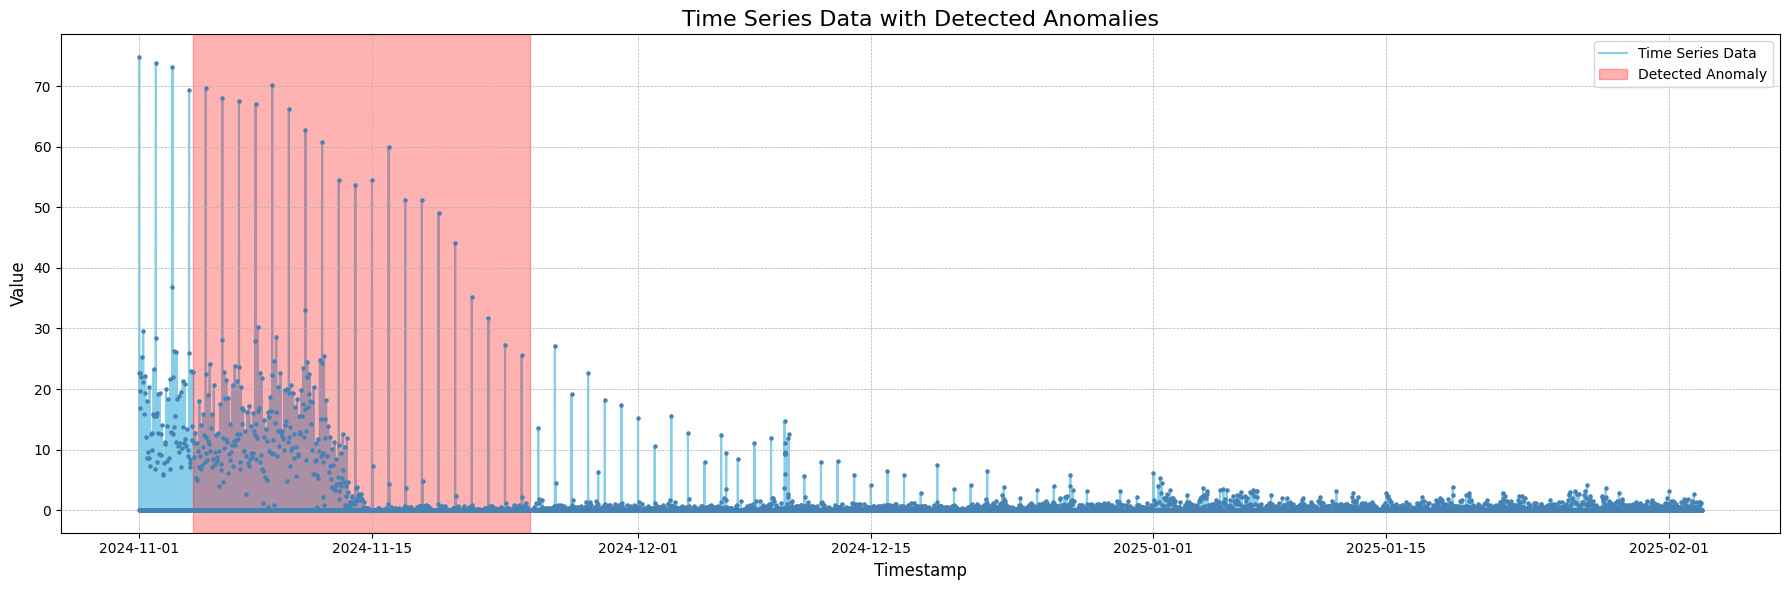

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

#
# Make sure the 'timestamp' column in the main data is in a readable format for plotting.
# The original 'data' DataFrame was modified to have integer timestamps,
# so we'll convert them back to datetime objects for the chart's x-axis.
#
plot_data = data.copy()
plot_data['timestamp'] = pd.to_datetime(plot_data['timestamp'], unit='s')


# Create the plot
plt.figure(figsize=(18, 6))
plt.plot(plot_data['timestamp'], plot_data['value'], label='Time Series Data', color='skyblue', zorder=1)
plt.scatter(plot_data['timestamp'], plot_data['value'], s=5, color='steelblue', zorder=2) # Add points for clarity

#
# Highlight each detected anomalous region.
# We iterate through the 'anomalies' DataFrame and draw a transparent red rectangle
# over each period that Orion has flagged.
#
for _, anomaly in anomalies.iterrows():
  start_time = pd.to_datetime(anomaly['start'], unit='s')
  end_time = pd.to_datetime(anomaly['end'], unit='s')
  plt.axvspan(start_time, end_time, color='red', alpha=0.3, label='Detected Anomaly')

#
# Improve the plot's readability with labels, a title, and a legend.
# To avoid duplicate labels in the legend, we'll handle them manually.
#
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Time Series Data with Detected Anomalies', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

For any questions, please open an issue on
[Orion github](https://github.com/sintel-dev/Orion), or [join our slack](https://join.slack.com/t/sintel-space/shared_invite/zt-q147oimb-4HcphcxPfDAM0O9_4PaUtw)!